# Algorithm Usage - simple_measures and Insights

This notebook demonstrates running A7 algorithms on XETR market data:
- **simple_measures**: Returns n levels of orderbook snapshots and trade metrics
- **Insights**: Provides trading statistics, trade events, and quote series

We'll use **DB1** (Deutsche Börse AG, Security ID: 2504978, Segment: 52885) on the **XETR** market.

## Setup

In [139]:
import os
from dotenv import load_dotenv
from a7 import A7Client

# Load environment variables from .env file
load_dotenv()

# Initialize client
api_token = os.getenv("A7_API_TOKEN")
base_url = os.getenv("A7_BASE_URL", "https://a7.deutsche-boerse.com/api/")
client = A7Client(token=api_token, base_url=base_url)

In [ ]:
target_date = 20251202  # Date in YYYYMMDD format (December 2, 2025)

## List Available Algorithms

In [ ]:
# We'll be using algorithms from Deutsche Börse AG (dbag owner)
print("Using algorithms: simple_measures and Insights from dbag (Deutsche Börse AG)")

Using algorithms: simple_measures and Insights from dbag (Deutsche Bank AG)


## Run simple_measures Algorithm

In [ ]:
# Run simple_measures on DB1 (Deutsche Börse AG) for XETR
simple_measures_result = client.algo.run(
    owner="dbag",
    algorithm="simple_measures",
    params={
        "date": target_date,
        "marketId": "XETR",
        "marketSegmentId": 52885,
        "securityId": 2504978
    }
)

print("simple_measures execution completed successfully!")

simple_measures execution completed successfully!


### Extract simple_measures Data

In [143]:
import pandas as pd

# Extract series data
series_data = simple_measures_result[0]['series']

# Convert each series to DataFrame
dataframes = {}
for series in series_data:
    name = series['name']
    content = series['content']
    # Content is already a list of records
    dataframes[name] = pd.DataFrame(content)
    print(f"\n{name} series: {len(content)} records")
    print(dataframes[name].head())  # Show first 5 rows, which is usually empty pre-market data

# Store for easy access
ob_df = dataframes['ob']
trd_df = dataframes['trd']


ob series: 8 records
                    ts bid_cnt  bid_qty  bid_prc  level  ask_prc  ask_qty  \
0  1764629100000000000    None      NaN      NaN      1      NaN      NaN   
1  1764629160000000000    None      NaN      NaN      1      NaN      NaN   
2  1764629220000000000    None      NaN      NaN      1      NaN      NaN   
3  1764629280000000000    None      NaN      NaN      1      NaN      NaN   
4  1764629340000000000    None      NaN      NaN      1      NaN      NaN   

  ask_cnt  
0    None  
1    None  
2    None  
3    None  
4    None  

trd series: 12 records
                    ts  open_prc  high_prc  low_prc  close_prc  vwap  qty  \
0  1764629100000000000       NaN       NaN      NaN        NaN   NaN  NaN   
1  1764629160000000000       NaN       NaN      NaN        NaN   NaN  NaN   
2  1764629220000000000       NaN       NaN      NaN        NaN   NaN  NaN   
3  1764629280000000000       NaN       NaN      NaN        NaN   NaN  NaN   
4  1764629340000000000       NaN  

In [144]:
# Show sample data from middle of trading day (rows 600-604)
print("\n=== Sample Trading Data (mid-day) ===")
print("\nOrderbook (ob) sample:")
print(ob_df.iloc[600:605])
print("\nTrade (trd) sample:")
print(trd_df.iloc[600:605])


=== Sample Trading Data (mid-day) ===

Orderbook (ob) sample:
                      ts bid_cnt  bid_qty  bid_prc  level  ask_prc  ask_qty  \
600  1764665100000000000       9    380.0    225.7      1    225.9    215.0   
601  1764665160000000000       9    532.0    225.6      1    225.8    124.0   
602  1764665220000000000       4    186.0    225.9      1    226.1    590.0   
603  1764665280000000000      10    345.0    226.1      1    226.3    363.0   
604  1764665340000000000       2     63.0    226.2      1    226.3    169.0   

    ask_cnt  
600       6  
601       2  
602       6  
603       7  
604       3  

Trade (trd) sample:
                      ts  open_prc  high_prc  low_prc  close_prc        vwap  \
600  1764665100000000000     225.8     225.8    225.8      225.8  225.800000   
601  1764665160000000000     225.8     225.8    225.6      225.6  225.658716   
602  1764665220000000000     225.7     225.9    225.7      225.9  225.805405   
603  1764665280000000000     226.0   

### Calculate Derived Metrics

In [145]:
# Calculate additional metrics from trade data
# Column mapping: open_prc, high_prc, low_prc, close_prc, vwap, qty, buy_qty, sell_qty, n_trd
trd_df['total_volume'] = trd_df['buy_qty'] + trd_df['sell_qty']
trd_df['price_range'] = trd_df['high_prc'] - trd_df['low_prc']
trd_df['buy_imbalance_pct'] = (trd_df['buy_qty'] / trd_df['total_volume'] * 100).round(2)
trd_df['sell_imbalance_pct'] = (trd_df['sell_qty'] / trd_df['total_volume'] * 100).round(2)

# Calculate orderbook metrics
# Column mapping: bid_prc, ask_prc, bid_qty, ask_qty
ob_df['spread'] = ob_df['ask_prc'] - ob_df['bid_prc']
ob_df['spread_bps'] = (ob_df['spread'] / ob_df['bid_prc'] * 10000).round(2)
ob_df['depth_imbalance'] = ob_df['bid_qty'] - ob_df['ask_qty']

print("Calculated metrics:")
print("\nTrade Summary:")
print(f"  Total Volume: {trd_df['total_volume'].sum():,.0f}")
print(f"  Avg Price Range: €{trd_df['price_range'].mean():.4f}")
print(f"  Avg Buy Imbalance: {trd_df['buy_imbalance_pct'].mean():.2f}%")

print("\nOrderbook Summary:")
print(f"  Avg Spread: €{ob_df['spread'].mean():.4f}")
print(f"  Avg Spread (bps): {ob_df['spread_bps'].mean():.2f}")
print(f"  Avg Depth Imbalance: {ob_df['depth_imbalance'].mean():,.0f}")

Calculated metrics:

Trade Summary:
  Total Volume: 134,091
  Avg Price Range: €0.0646
  Avg Buy Imbalance: 41.68%

Orderbook Summary:
  Avg Spread: €0.3434
  Avg Spread (bps): 15.27
  Avg Depth Imbalance: 67


### Visualize simple_measures Data

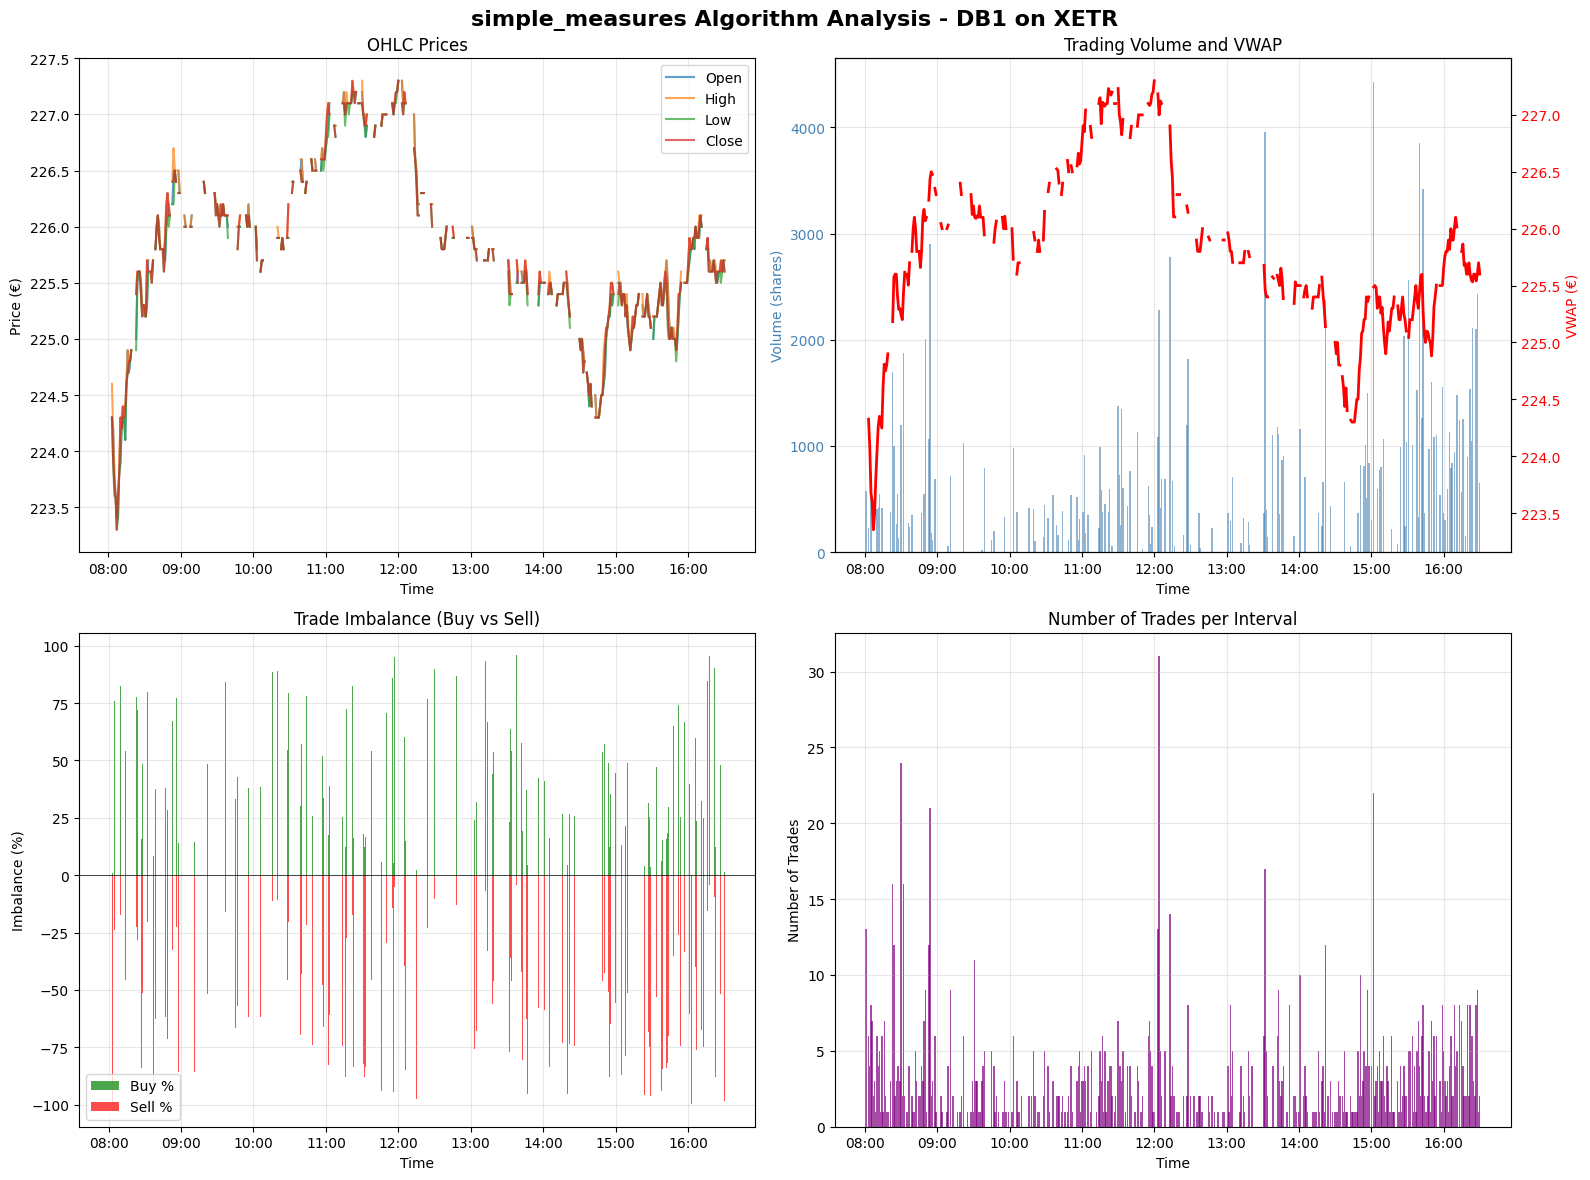

In [146]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Convert timestamp strings to integers, then to datetime
# The timestamps are in nanoseconds, convert to seconds then to datetime (UTC)
trd_df['dt'] = pd.to_datetime(trd_df['ts'].astype(int), unit='ns', utc=True)
ob_df['dt'] = pd.to_datetime(ob_df['ts'].astype(int), unit='ns', utc=True)

# Convert to CET (Europe/Berlin) timezone for XETR market
trd_df['dt'] = trd_df['dt'].dt.tz_convert('Europe/Berlin')
ob_df['dt'] = ob_df['dt'].dt.tz_convert('Europe/Berlin')

# Convert n_trd to numeric, replacing None with NaN
trd_df['n_trd_numeric'] = pd.to_numeric(trd_df['n_trd'], errors='coerce')

# Create 2x2 subplot figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('simple_measures Algorithm Analysis - DB1 on XETR', fontsize=16, fontweight='bold')

# 1. OHLC Prices
ax1.plot(trd_df['dt'], trd_df['open_prc'], label='Open', alpha=0.7)
ax1.plot(trd_df['dt'], trd_df['high_prc'], label='High', alpha=0.7)
ax1.plot(trd_df['dt'], trd_df['low_prc'], label='Low', alpha=0.7)
ax1.plot(trd_df['dt'], trd_df['close_prc'], label='Close', alpha=0.7)
ax1.set_title('OHLC Prices')
ax1.set_xlabel('Time')
ax1.set_ylabel('Price (€)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# 2. Volume and VWAP
ax2_twin = ax2.twinx()
ax2.bar(trd_df['dt'], trd_df['total_volume'], alpha=0.6, color='steelblue', label='Volume', width=0.0008)
ax2_twin.plot(trd_df['dt'], trd_df['vwap'], color='red', linewidth=2, label='VWAP')
ax2.set_title('Trading Volume and VWAP')
ax2.set_xlabel('Time')
ax2.set_ylabel('Volume (shares)', color='steelblue')
ax2_twin.set_ylabel('VWAP (€)', color='red')
ax2.tick_params(axis='y', labelcolor='steelblue')
ax2_twin.tick_params(axis='y', labelcolor='red')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax2.grid(True, alpha=0.3)

# 3. Buy/Sell Imbalance
width = pd.Timedelta(minutes=0.5)
ax3.bar(trd_df['dt'], trd_df['buy_imbalance_pct'], width=width, alpha=0.7, color='green', label='Buy %')
ax3.bar(trd_df['dt'], -trd_df['sell_imbalance_pct'], width=width, alpha=0.7, color='red', label='Sell %')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax3.set_title('Trade Imbalance (Buy vs Sell)')
ax3.set_xlabel('Time')
ax3.set_ylabel('Imbalance (%)')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# 4. Trading Activity - filter out NaN values
trd_df_filtered = trd_df[trd_df['n_trd_numeric'].notna()]
ax4.bar(trd_df_filtered['dt'], trd_df_filtered['n_trd_numeric'], alpha=0.7, color='purple', width=0.0008)
ax4.set_title('Number of Trades per Interval')
ax4.set_xlabel('Time')
ax4.set_ylabel('Number of Trades')
ax4.grid(True, alpha=0.3)
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.tight_layout()
plt.show()

### Summary Table - Trade Metrics

In [147]:
# Create summary statistics table
summary_stats = pd.DataFrame({
    'Metric': [
        'Total Volume',
        'Avg Price',
        'Price Range (High - Low)',
        'Avg VWAP',
        'Total Trades',
        'Avg Trades per Interval',
        'Avg Buy Volume',
        'Avg Sell Volume',
        'Avg Buy Imbalance %'
    ],
    'Value': [
        f"{trd_df['total_volume'].sum():,.0f}",
        f"€{trd_df['close_prc'].mean():.4f}",
        f"€{(trd_df['high_prc'].max() - trd_df['low_prc'].min()):.4f}",
        f"€{trd_df['vwap'].mean():.4f}",
        f"{trd_df['n_trd_numeric'].sum():,.0f}",
        f"{trd_df['n_trd_numeric'].mean():.2f}",
        f"{trd_df['buy_qty'].mean():,.0f}",
        f"{trd_df['sell_qty'].mean():,.0f}",
        f"{trd_df['buy_imbalance_pct'].mean():.2f}%"
    ]
})

print("Trade Metrics Summary")
print("=" * 50)
print(summary_stats.to_string(index=False))
print("=" * 50)

Trade Metrics Summary
                  Metric     Value
            Total Volume   134,091
               Avg Price €225.7667
Price Range (High - Low)   €4.0000
                Avg VWAP €225.7635
            Total Trades     1,241
 Avg Trades per Interval      3.60
          Avg Buy Volume       242
         Avg Sell Volume       424
     Avg Buy Imbalance %    41.68%


## Run Insights Algorithm

In [148]:
# Run Insights algorithm on same instrument
insights_result = client.algo.run(
    owner="dbag",
    algorithm="Insights",
    params={
        "date": target_date,
        "marketId": "XETR",
        "marketSegmentId": 52885,
        "securityId": 2504978
    }
)

print("Insights execution completed successfully!")

Insights execution completed successfully!


### Extract Insights Data

In [149]:
# Extract Insights series data
insights_series = insights_result[0]['series']

# Convert each series to DataFrame
insights_dfs = {}
for series in insights_series:
    name = series['name']
    content = series['content']
    # Content is a list of records
    insights_dfs[name] = pd.DataFrame(content)
    print(f"\n{name} series: {len(content)} records")
    print(insights_dfs[name].head())

# Store for easy access  
trades_df = insights_dfs['Trades']
quotes_df = insights_dfs['Quotes']

# The Insights algorithm provides Trades and Quotes data
# Calculate stats from the Quotes data
print(f"\nAvailable series: {list(insights_dfs.keys())}")


Trades series: 3 records
   Price  Quantity            Timestamp
0  224.9         5  1764660091566361502
1  223.3      5523  1764662402237019972
2  223.6         1  1764662405080169053
3  223.6         3  1764662405080172213
4  223.6        17  1764662405080172213

Quotes series: 8 records
   Ask AskDepth  AskQty  Bid BidDepth  BidQty            Timestamp Volume
0  NaN     None     NaN  NaN     None     NaN  1764633600000000000   None
1  NaN     None     NaN  NaN     None     NaN  1764633660000000000   None
2  NaN     None     NaN  NaN     None     NaN  1764633720000000000   None
3  NaN     None     NaN  NaN     None     NaN  1764633780000000000   None
4  NaN     None     NaN  NaN     None     NaN  1764633840000000000   None

Available series: ['Trades', 'Quotes']


### Calculate Insights Metrics

In [150]:
# Convert timestamps for Quotes data
quotes_df['dt'] = pd.to_datetime(quotes_df['Timestamp'].astype(int) / 1000, unit='us')

# Convert timestamps for Trades data  
trades_df['dt'] = pd.to_datetime(trades_df['Timestamp'].astype(int) / 1000, unit='us')

# Convert numeric columns
for col in ['Ask', 'Bid', 'AskQty', 'BidQty', 'AskDepth', 'BidDepth', 'Volume']:
    if col in quotes_df.columns:
        quotes_df[col] = pd.to_numeric(quotes_df[col], errors='coerce')

for col in ['Price', 'Quantity', 'Volume']:
    if col in trades_df.columns:
        trades_df[col] = pd.to_numeric(trades_df[col], errors='coerce')

# Calculate spread and mid price from Quotes
quotes_df['Spread'] = quotes_df['Ask'] - quotes_df['Bid']
quotes_df['MidPrice'] = (quotes_df['Ask'] + quotes_df['Bid']) / 2
quotes_df['spread_bps'] = (quotes_df['Spread'] / quotes_df['Bid'] * 10000).round(2)
quotes_df['total_depth'] = quotes_df['BidDepth'] + quotes_df['AskDepth']

print("Insights Metrics Summary:")
print(f"  Trades: {len(trades_df)} events")
print(f"  Total Quantity: {trades_df['Quantity'].sum():,.0f}")
print(f"  Avg Trade Price: €{trades_df['Price'].mean():.4f}")
print(f"\nQuotes Summary (with data):")
quotes_with_data = quotes_df[quotes_df['MidPrice'].notna()]
if len(quotes_with_data) > 0:
    print(f"  Avg Spread: €{quotes_with_data['Spread'].mean():.4f}")
    print(f"  Avg Spread (bps): {quotes_with_data['spread_bps'].mean():.2f}")
    print(f"  Avg Mid Price: €{quotes_with_data['MidPrice'].mean():.4f}")
else:
    print("  No quote data available")

Insights Metrics Summary:
  Trades: 2581 events
  Total Quantity: 377,993
  Avg Trade Price: €225.7375

Quotes Summary (with data):
  Avg Spread: €0.2519
  Avg Spread (bps): 11.19
  Avg Mid Price: €225.6755


### Visualize Insights Data

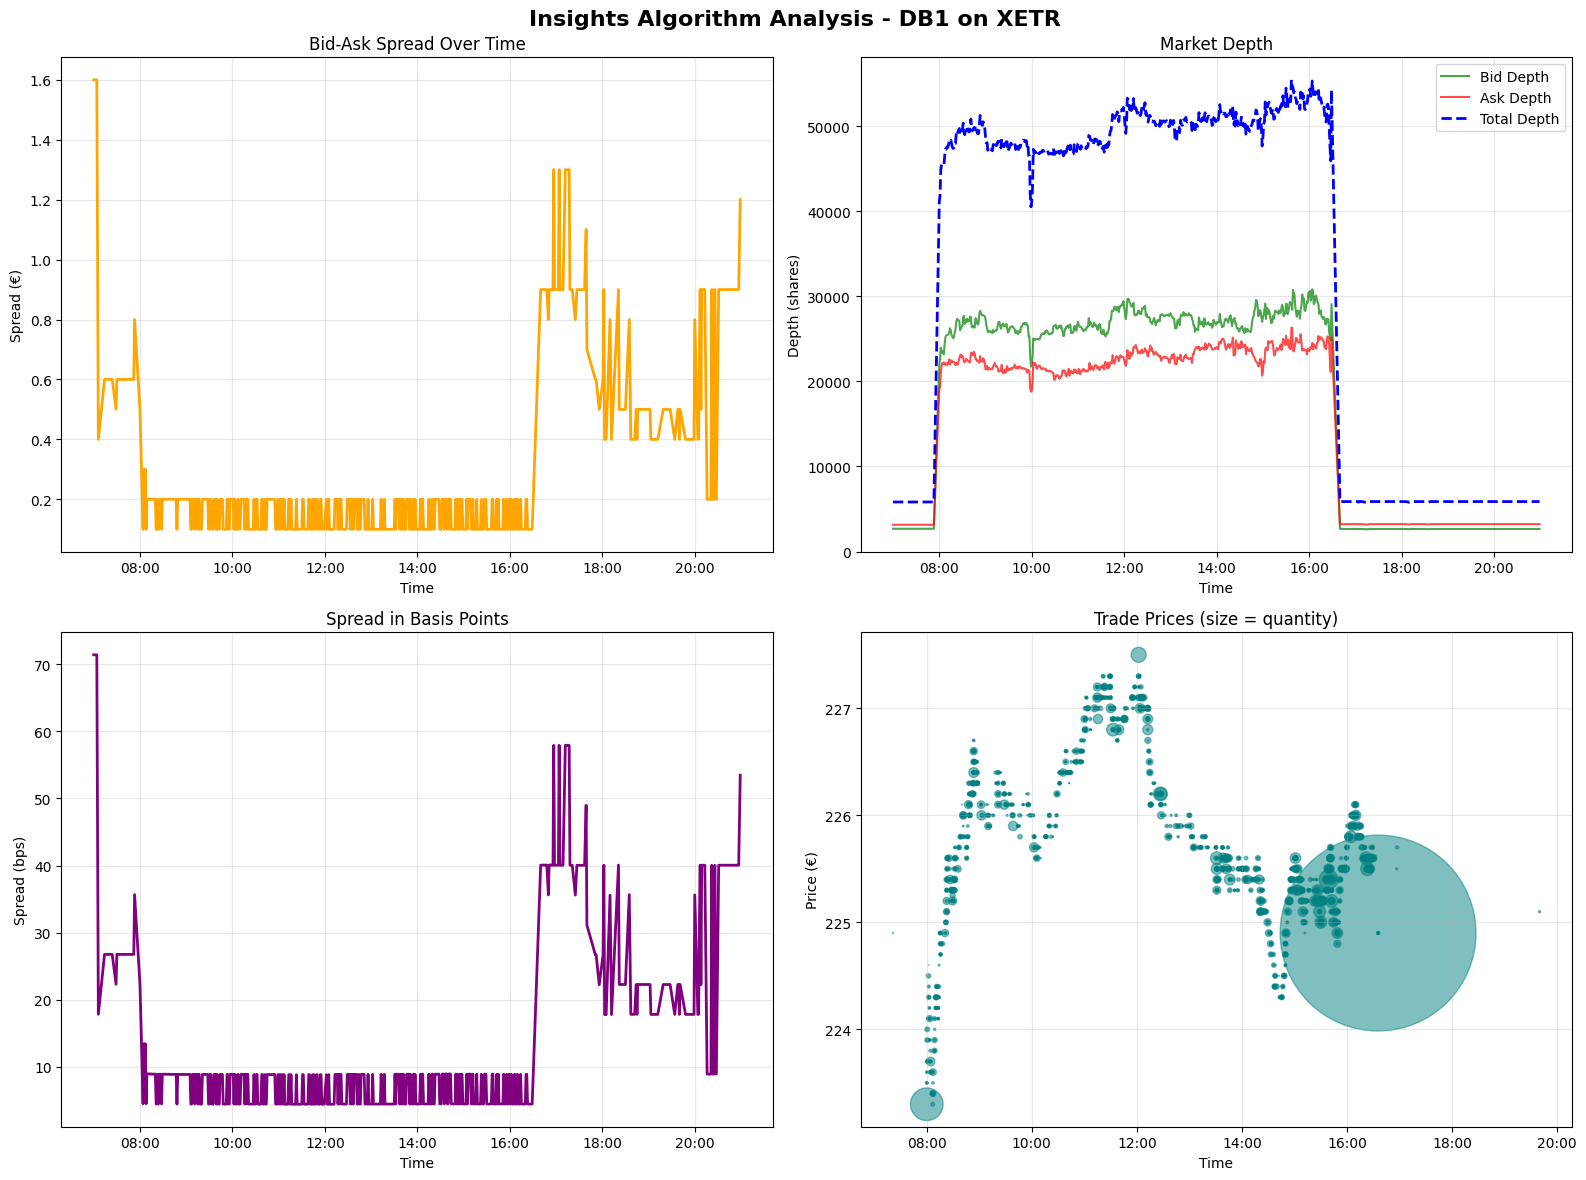

In [151]:
# Create 2x2 subplot figure for Insights
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Insights Algorithm Analysis - DB1 on XETR', fontsize=16, fontweight='bold')

# Filter quotes with valid data
quotes_valid = quotes_df[quotes_df['MidPrice'].notna()]

if len(quotes_valid) > 0:
    # 1. Bid-Ask Spread
    ax1.plot(quotes_valid['dt'], quotes_valid['Spread'], color='orange', linewidth=2)
    ax1.set_title('Bid-Ask Spread Over Time')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Spread (€)')
    ax1.grid(True, alpha=0.3)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    # 2. Market Depth
    ax2.plot(quotes_valid['dt'], quotes_valid['BidDepth'], label='Bid Depth', color='green', alpha=0.7)
    ax2.plot(quotes_valid['dt'], quotes_valid['AskDepth'], label='Ask Depth', color='red', alpha=0.7)
    ax2.plot(quotes_valid['dt'], quotes_valid['total_depth'], label='Total Depth', color='blue', linewidth=2, linestyle='--')
    ax2.set_title('Market Depth')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Depth (shares)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    # 3. Spread in Basis Points
    ax3.plot(quotes_valid['dt'], quotes_valid['spread_bps'], color='purple', linewidth=2)
    ax3.set_title('Spread in Basis Points')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Spread (bps)')
    ax3.grid(True, alpha=0.3)
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
else:
    ax1.text(0.5, 0.5, 'No quote data available', ha='center', va='center', transform=ax1.transAxes)
    ax2.text(0.5, 0.5, 'No quote data available', ha='center', va='center', transform=ax2.transAxes)
    ax3.text(0.5, 0.5, 'No quote data available', ha='center', va='center', transform=ax3.transAxes)

# 4. Trade Prices Over Time
ax4.scatter(trades_df['dt'], trades_df['Price'], alpha=0.5, s=trades_df['Quantity']/10, color='teal')
ax4.set_title('Trade Prices (size = quantity)')
ax4.set_xlabel('Time')
ax4.set_ylabel('Price (€)')
ax4.grid(True, alpha=0.3)
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.tight_layout()
plt.show()

### Summary Table - Market Microstructure

In [152]:
# Create summary table from Insights data
quotes_valid = quotes_df[quotes_df['MidPrice'].notna()]

if len(quotes_valid) > 0:
    microstructure_stats = pd.DataFrame({
        'Metric': [
            'Total Trades',
            'Total Trade Quantity',
            'Avg Trade Price',
            'Avg Mid Price (Quotes)',
            'Avg Spread',
            'Avg Spread (bps)',
            'Min Spread',
            'Max Spread',
            'Avg Bid Depth',
            'Avg Ask Depth'
        ],
        'Value': [
            f"{len(trades_df):,.0f}",
            f"{trades_df['Quantity'].sum():,.0f}",
            f"€{trades_df['Price'].mean():.4f}",
            f"€{quotes_valid['MidPrice'].mean():.4f}",
            f"€{quotes_valid['Spread'].mean():.4f}",
            f"{quotes_valid['spread_bps'].mean():.2f}",
            f"€{quotes_valid['Spread'].min():.4f}",
            f"€{quotes_valid['Spread'].max():.4f}",
            f"{quotes_valid['BidDepth'].mean():,.0f}",
            f"{quotes_valid['AskDepth'].mean():,.0f}"
        ]
    })
else:
    microstructure_stats = pd.DataFrame({
        'Metric': ['Total Trades', 'Total Trade Quantity', 'Avg Trade Price'],
        'Value': [
            f"{len(trades_df):,.0f}",
            f"{trades_df['Quantity'].sum():,.0f}",
            f"€{trades_df['Price'].mean():.4f}"
        ]
    })

print("Market Microstructure Summary (Insights)")
print("=" * 50)
print(microstructure_stats.to_string(index=False))
print("=" * 50)

Market Microstructure Summary (Insights)
                Metric     Value
          Total Trades     2,581
  Total Trade Quantity   377,993
       Avg Trade Price €225.7375
Avg Mid Price (Quotes) €225.6755
            Avg Spread   €0.2519
      Avg Spread (bps)     11.19
            Min Spread   €0.1000
            Max Spread   €1.6000
         Avg Bid Depth    22,550
         Avg Ask Depth    19,153


## Summary

This notebook demonstrates two powerful algorithms from Deutsche Börse AG:

1. **simple_measures**: Provides comprehensive trade and orderbook metrics including OHLC prices, volume analysis, VWAP, and trade imbalances.

2. **Insights**: Delivers detailed market microstructure data including bid-ask spreads, market depth, and liquidity metrics.

Both algorithms were executed on **DB1 (Deutsche Börse AG)** for the **XETR** market, providing valuable insights into trading dynamics and market quality.